In [9]:
from transformers import BertTokenizer, TFBertForQuestionAnswering
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

c:\Users\charl\miniconda3\envs\mat099\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1-squad")

In [3]:
model = TFBertForQuestionAnswering.from_pretrained("dmis-lab/biobert-base-cased-v1.1-squad", from_pt=True)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [4]:
question = "What reduces risk of Covid-19?"
text = """
Coronavirus (COVID-19) can make anyone seriously ill. But for some people, the risk is higher.
At some point during the COVID-19 pandemic you may have been told you were at high risk of getting seriously ill from COVID-19 (sometimes called clinically vulnerable or clinically extremely vulnerable). You may also have been advised to stay at home (shield).
For most people at high risk from COVID-19, vaccination has significantly reduced this risk. You can follow the same advice as everyone else on how to avoid catching and spreading COVID-19.
Some people continue to be at high risk from COVID-19, despite vaccination.
"""

In [5]:
inputs = tokenizer(question, text, return_tensors="tf")
outputs = model(**inputs)

In [6]:
answer_start_index = int(tf.math.argmax(outputs.start_logits, axis=-1)[0])
answer_end_index = int(tf.math.argmax(outputs.end_logits, axis=-1)[0])

In [7]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]

In [8]:
tokenizer.decode(predict_answer_tokens)

'vaccination'

Potential approach for TF-IDF cosine similarity:
1. Extraction of titles from all JSON documents.
2. Getting the list of embeddings for all the titles using BERT.
3. Finding the embedding for the input query using BERT
4. Using Cosine similarity, to find the list of similar embeddings to that of input query. This generate the list of titles which are similar to the input query. 

Could extend this to search in the text body after. Recommend starting with a small amount of self-generated text to test approach.

In [4]:
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm

In [17]:
data = pd.read_csv("Data/clean_pmc.csv", nrows=1000)

In [85]:
not_null_data = data[data['abstract'].notnull()]
# not_null_data.reset_index(inplace=True, drop=True)

In [86]:
not_null_data.shape

(662, 9)

In [20]:
def get_answer(question, text):
    
    inputs = tokenizer(question, text, return_tensors="tf")
    outputs = model(**inputs)
    answer_start_index = int(tf.math.argmax(outputs.start_logits, axis=-1)[0])
    answer_end_index = int(tf.math.argmax(outputs.end_logits, axis=-1)[0])
    predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
    predicted_answer = tokenizer.decode(predict_answer_tokens)

    return predicted_answer

In [66]:
question = "What are the risk factors of Covid-19?"

qa_results=[]
for index, row in tqdm(not_null_data.iterrows(), total=not_null_data.shape[0]):

    if len(tokenizer.tokenize(row['abstract'])) < 475:
        
        text = row['abstract']
        predicted_answer = get_answer(question=question, text=text)
        
        if predicted_answer != '[CLS]' and predicted_answer != '':
            qa_results.append((index, predicted_answer))

In [5]:
# qa_results = joblib.dump(qa_results, 'outputs/bert_qa_results_500.pkl')
qa_results = joblib.load('outputs/bert_qa_results_500.pkl')

In [23]:
len(['age', 'gender', 'sex', 'pneumonia', 'obesity', 'weight', 'diabetes', 'smoking', 'cardiovascular', 'location', 'contact', 'asthma', 'cancer'])

13

In [24]:
# original candidate risk factors
# ['age', 'gender', 'sex', 'pneumonia', 'obesity', 'diabetes', 'smoking', 'cardiovascular', 'location', 'contact', 'asthma', 'cancer']

In [28]:
# updated risk factors from word2vec
age_synonyms = ['age', 'younger', 'older', 'ages', 'aged', 'old']
gender_synonyms = ['gender', 'ethnicity', 'sex', 'demographics', 'occupation', 'nationality']
sex_synonyms = ['sex', 'gender', 'ethnicity', 'breed', 'race/ethnicity', 'occupation']
pneumonia_synonyms = ['pneumonia', 'pneumonias', 'tracheitis', 'croup', 'pharyngitis', 'bronchiolitis']
obesity_synonyms = ['obesity', 'diabetes', 'hypertension', 'malnutrition', 'osteoporosis', 'nafld']
diabetes_synonyms = ['diabetes', 'mellitus', 'obesity', 'hypertension', 'insulin-dependent', 'hypercholesterolemia']
smoking_synonyms = ['smoking', 'cigarette', 'smoke', 'obesity', 'abuse', 'breastfeeding']
cardiovascular_synonyms = ['cardiovascular', 'cardiopulmonary', 'cardiac', 'cerebrovascular', 'hypertension', 'musculoskeletal']
location_synonyms = ['location', 'locations', 'geographical', 'distribution', 'geographic', 'temporal']
contact_synonyms = ['contact', 'contacts', 'transmission', 'proximity', 'movement', 'exposure']
asthma_synonyms = ['asthma', 'wheezing', 'copd', 'exacerbations', 'atopy', 'wheeze']
cancer_synonyms = ['cancer', 'cancers', 'carcinoma', 'prostate', 'melanoma', 'tumour']

candidate_risk_factors = set(age_synonyms + gender_synonyms + sex_synonyms + pneumonia_synonyms + obesity_synonyms + diabetes_synonyms + smoking_synonyms + cardiovascular_synonyms + location_synonyms + contact_synonyms + asthma_synonyms + cancer_synonyms)

In [30]:
risk_factor_list=[]
for result in qa_results:
    for risk_factor in candidate_risk_factors:
        if risk_factor in result[1].split():
            # print(result[0], risk_factor, result[1])
            risk_factor_list.append(risk_factor)

print(risk_factor_list)

['distribution', 'exacerbations', 'asthma', 'croup', 'wheezing', 'age', 'older', 'age', 'contact', 'transmission', 'transmission', 'pneumonia', 'bronchiolitis', 'old', 'exposure', 'pneumonia', 'age', 'bronchiolitis', 'exposure', 'age', 'older', 'age', 'cancer', 'asthma', 'occupation']


In [17]:
print(not_null_data['abstract'][863])

NameError: name 'not_null_data' is not defined

In [31]:
risk_factor_count = Counter(risk_factor_list)
print(risk_factor_count)

Counter({'age': 5, 'asthma': 2, 'older': 2, 'transmission': 2, 'pneumonia': 2, 'bronchiolitis': 2, 'exposure': 2, 'distribution': 1, 'exacerbations': 1, 'croup': 1, 'wheezing': 1, 'contact': 1, 'old': 1, 'cancer': 1, 'occupation': 1})


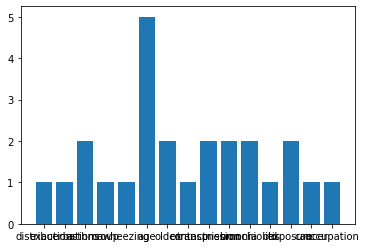

In [32]:
plt.bar(risk_factor_count.keys(), risk_factor_count.values())
plt.show()

**Next steps**:

- Do initial QA
- Run on full data
- Type up results in dissertation
- Run and write up error analysis

To consider (time dependent):
- Write code to truncate to 512 tokens for if abstracts are bigger.